In [1]:
#General
import re
import pandas as pd
import numpy as np
import string
import os
import string
from os import listdir
import itertools
from itertools import chain


import random, collections
from tqdm import tqdm_notebook as tqdm


#Nltk processes
import nltk
import numpy
import string
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import PlaintextCorpusReader
from collections import Counter
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.collocations import ngrams




#WordNet
from nltk.corpus import wordnet as wn
#Sentiment, SentiWordNet
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA #VADER
from nltk.sentiment import sentiment_analyzer, util
from nltk.sentiment import SentimentAnalyzer
from textblob import TextBlob

#Classifers


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
#from sklearn import cross_validation

import gensim
from gensim.models import phrases, word2vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.metrics import roc_curve, roc_auc_score

from nltk import word_tokenize
from nltk.sentiment.util import mark_negation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.base import TransformerMixin

from nltk import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import extract_unigram_feats, mark_negation

#Lemmatization & Stemming
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer, PorterStemmer


#Visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objects as go
import plotly.express as px

/Users/sevde/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# ALL DATA

# FAKE REVIEW TRAINING & TEST DATA

In [2]:
#Train and test corpus for fake review detection YELP DATASET

#Loading metadata
metadata = pd.read_csv('metadata', delimiter = '\t')
metadata.columns = ["user_id", "restaurant_id", "rating", "label", "date"]

#Loading review content
review_content = pd.read_csv("reviewContent", delimiter = '\t')
review_content.columns = ["user_id", "restaurant_id", "date", "raw_review"]

#Merging these two data and dropping the repetitive columns
data = pd.merge(metadata, review_content, on = ["user_id", "restaurant_id", "date"])
#data.drop(columns = ["user_id2", "restaurant_id", "date2"], inplace = True)

#Counting and deleting Nan
print(data.isna().sum())
data.dropna(inplace = True)

##Shuffle the data and get a part of it (5000 reviews for train and test)
deceptive_df = data.sample(frac=1)[0:10000]
deceptive_df.reset_index(inplace = True)

user_id          0
restaurant_id    0
rating           0
label            0
date             0
raw_review       0
dtype: int64


In [3]:
print(Counter(deceptive_df['label']), Counter(metadata['label']))
print(metadata.shape, review_content.shape, data.shape)

Counter({1: 9015, -1: 985}) Counter({1: 322167, -1: 36884})
(359051, 5) (358956, 4) (358956, 6)


# PRODUCT REVIEW DATA

In [4]:
#AMAZON PRODUCT REVIEWS TO BE ANALYZED --******** The size of Electronics_Reviews dataset is too big. So that the final
                                        #******** "product_df" in this code was saved in csv format and added to the 
                                        #********* .zip file in the supporting file submission

#category_reviews = pd.read_csv("Electronics_Reviews.csv")
#unnamed_columns_to_drop = ['Unnamed: 15', 'Unnamed: 16','Unnamed: 17','Unnamed: 18','Unnamed: 19','Unnamed: 20','Unnamed: 21']
#if  set([True for column in unnamed_columns_to_drop if column in list(category_reviews.columns)]):
    #category_reviews.drop(columns = unnamed_columns_to_drop , axis = 1, inplace=True)
#products = ["Panasonic ErgoFit In-Ear Earbud Headphone","MEElectronics Sport-Fi M6 Noise Isolating In-Ear Headphones with Memory Wire","Symphonized NRG Premium Genuine Wood In-ear Noise-isolating Headphones|Earbuds|Earphones with Microphone", "Bose SoundTrue In-Ear Headphones"]



#p1 = category_reviews[category_reviews["product_title"] == "Panasonic ErgoFit In-Ear Earbud Headphone"][0:1240]
#p1['product'] = ['product1']*p1.shape[0]

#p2 = category_reviews[category_reviews["product_title"] == "MEElectronics Sport-Fi M6 Noise Isolating In-Ear Headphones with Memory Wire"][0:1240]
#p2['product'] = ['product2']*p2.shape[0]

#p3 = category_reviews[category_reviews["product_title"] == "Symphonized NRG Premium Genuine Wood In-ear Noise-isolating Headphones|Earbuds|Earphones with Microphone"][0:1240]
#p3['product'] = ['product3']*p3.shape[0]

#p4 = category_reviews[category_reviews["product_title"] == "Bose SoundTrue In-Ear Headphones"]
#p4['product'] = ['product4']*p4.shape[0]

#product_df = pd.concat([p1,p2,p3,p4], axis = 0)



In [16]:
#product_df.to_csv("product_df.csv")
product_df = pd.read_csv("product_df.csv")
columns_to_drop = ['Unnamed: 0']
if  set([True for column in columns_to_drop if column in list(product_df.columns)]):
    product_df.drop(columns = columns_to_drop , axis = 1, inplace=True)

In [17]:
deceptive_df.shape, product_df.shape

((10000, 7), (4960, 16))

GETTING THE SENTIMENTS OF PRODUCT REVIEWS 

In [7]:
##GETTING THE SENTIMENTS OF THE REVIEWS
sentiment = []
polarity = []
for i in range(product_df.shape[0]):
    polarity.append(TextBlob(product_df.iloc[i]["review_body"]).sentiment.polarity)
    if TextBlob(product_df.iloc[i]["review_body"]).sentiment.polarity > 0.1:
        sentiment.append("1")
    else:
        sentiment.append("0")      

In [8]:
product_df['polarity'] = polarity

In [8]:
product_df['sentiment'] = sentiment
columns_to_drop = ['product_id', 'product_parent', 'marketplace', 'review_id', 'product_category', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline']
if  set([True for column in columns_to_drop if column in list(product_df.columns)]):
    product_df.drop(columns = columns_to_drop , inplace = True)






In [9]:
print("each headphone corpus size:", p1.shape, p2.shape, p3.shape, p4.shape)
print("the whole corpus size:",product_df.shape)
print(" ")
print("Is there NaN values ")
print(product_df.isna().sum())

each headphone corpus size: (1240, 16) (1240, 16) (1240, 16) (1240, 16)
the whole corpus size: (4960, 8)
 
Is there NaN values 
customer_id      0
product_title    0
star_rating      0
review_body      0
review_date      0
product          0
polarity         0
sentiment        0
dtype: int64


In [10]:
product_df.reset_index(drop = True, inplace = True)
product_df['sentiment'].value_counts()

1    4101
0     859
Name: sentiment, dtype: int64

# PREPROCESSING AND FEATURE EXTRACTION FUNCTIONS

# 1)Preprocess

In [280]:
def lemmatizer(tokens):
    wnet_lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in nltk.pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(wnet_lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

def preprocess(reviews, operation, specific_words_to_remove, specific_adjectives_to_remove):
    stop_words = stopwords.words("english")
    extra_stop_words = ["arent", "werent", "wasnt", "doesnt", "dont", "didnt", "wont", "isnt", "hasnt", "havent", "hadnt",\
                            "couldnt", "shouldnt", "cant", "lets", "mustnt", "im", "youre", "ive", "shouldve" "shes", "hes", "its",\
                         "theyre", "st", "nd", "rd", "th", "gonna","wouldnt", "id", "youd", "youve", "weve", "theyve", \
                       "wanna", "thats", "hi", "theyre","nt","ca", "st", "nd", "rd", "th", "gonna","wouldnt", "id", "youd", "youve", "weve", "theyve", \
                        "wanna", "thats", "hi", "lets", "ive", "shes", "hes", "its", "im" ] 

    
    if operation == "general":
        process0 = ( " ".join(review.split("<br />")) for review in reviews )
        process1 = ((re.sub(r'[`\-=~!@#$%^&*()_+\[\]{};\\\:"|<,./<>?]',"", review)) for review in tqdm(process0))
        process2 = ((re.sub("[^a-zA-Z\d\s:]", "", review)) for review in process1)
        process3 = ((re.sub("[\d-]", "", review)) for review in process1)
        tokenized = ((word_tokenize(str(review).lower())) for review in process3)
        process4 = ([w for w in review if not w in extra_stop_words + stop_words + specific_words_to_remove + specific_adjectives_to_remove] for review in tokenized)
        process5 = (lemmatizer(review)for review in process4)
        process6 =([w for w in review if len(w) > 2 and "'" not in w] for review in process5)
        joined = [" ".join(review) for review in process6]
        return joined
    
    elif operation == "slight":
        process0 = ( " ".join(review.split("<br />")) for review in reviews )
        punct = [x for x in list(string.punctuation) if x != "."]
        process1 = ((re.sub("[\d-]", "", review)) for review in tqdm(process0))
        tokenized = ((word_tokenize(str(review).lower())) for review in process1)
        process2 = (lemmatizer(review) for review in tokenized)
        process3 =([w for w in review if w not in punct + specific_words_to_remove + specific_adjectives_to_remove] for review in process2)
        joined = [" ".join(review) for review in process3]
        return joined

    
    elif operation == "nouns":
        cleaned_reviews = []
        for review in tqdm(reviews):
            is_noun = lambda pos: pos[:2] == 'NN'
            process0 = " ".join(review.split("<br />"))
            tokenized = word_tokenize(str(process0).lower())
            all_nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
            process1 = [re.sub(r'[`\-=~!@#$%^&*()_+\[\]{};\\\:"|<,./<>?]',"", w) for w in all_nouns]
            process2 = [re.sub("[^a-zA-Z\d\s:]", "", w) for w in process1]
            process3 = [re.sub("[\d-]", "", w) for w in process2]
            process4 = [w for w in process3 if not w in extra_stop_words + stop_words + specific_words_to_remove]
            process5 = [w for w in process4 if len(w) > 2]
            process6 = [lemmatizer(w) for w in process5]
            joined = " ".join(process6) 
            cleaned_reviews.append(joined)
        return cleaned_reviews
    
    elif operation == "adjectives":
        cleaned_reviews = []
        for review in tqdm(reviews):
            is_noun = lambda pos: pos[:2] == 'JJ'
            process0 = " ".join(review.split("<br />"))
            tokenized = word_tokenize(str(process0).lower())
            all_nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
            process1 = [re.sub(r'[`\-=~!@#$%^&*()_+\[\]{};\\\:"|<,./<>?]',"", w) for w in all_nouns]
            process2 = [re.sub("[^a-zA-Z\d\s:]", "", w) for w in process1]
            process3 = [re.sub("[\d-]", "", w) for w in process2]
            process4 = [w for w in process3 if not w in extra_stop_words + stop_words + specific_adjectives_to_remove]
            process5 = [w for w in process4 if len(w) > 2]
            process6 = [lemmatizer(w) for w in process5]
            joined = " ".join(process6) 
            cleaned_reviews.append(joined)
        return cleaned_reviews    


# 2)Feature Extraction Functions

REVIEW-CENTRIC FEATURE FUNCTIONS

In [12]:

###REVIEW CENTRIC

def review_length(reviews):
    return [len(str(review).split()) for review in reviews]

def review_avg_word_length(reviews):
    avg_word_length_list = []
    for review in reviews:
        
        clean = [re.sub(r'[`\-=􏰱!@#$%^&*()_+\[\]􏰦􏰬;\\\:"􏰿<,./<>?]',"", w) for w in nltk.word_tokenize(str(review))]
        word_lengths = [len(word) for word in clean]
        average_word_length = sum(word_lengths)/len(word_lengths)
        avg_word_length_list.append(average_word_length)
    return avg_word_length_list

def review_sentence_count(reviews): 
    return [len(nltk.sent_tokenize(review)) for review in reviews]

def review_capital_count(reviews):
    return [sum(map(str.isupper, review)) for review in reviews]

def review_punctuation_count(reviews):
    punct_count = []
    for review in reviews:
        counter = [1 for character in review if character in string.punctuation]
        punct_count.append(sum(counter))
    return punct_count

def review_postag_percentage(reviews):
    postag_df = pd.DataFrame()
    from nltk.data import load
    tagdict = load('help/tagsets/upenn_tagset.pickle')
    global pos_tags
    pos_tags = [tag for tag in list(tagdict.keys())]
    
    tagged_reviews = (nltk.pos_tag(nltk.word_tokenize(str(review))) for review in reviews)
    all_pos_percentages = []
    for tagged_review in tqdm(tagged_reviews):
        review_pos_percentages = {}
        for pos_tag in pos_tags:
            if tagged_review == []:
                break
            percentage = sum([1 for tag in tagged_review if tag[1] == pos_tag])/len(tagged_review)
            review_pos_percentages[pos_tag] = percentage
        all_pos_percentages.append(review_pos_percentages)
        
    return postag_df.append(all_pos_percentages)
        

##N-GRAM FEATURES

def review_ngram(reviews,operation, a, b):

    
    if operation.lower() == "ngram":
        tfidf = TfidfVectorizer(ngram_range = (a,b))
        vect =tfidf.fit_transform(reviews)
        return (vect,tfidf)

    ##VISUALISATION
    
    if operation.lower() == "unigram graphs":
        tokenized_reviews = (nltk.word_tokenize(str(review)) for review in reviews)
        all_words = []
        for review in tokenized_reviews:
            for word in review:
                all_words.append(word)
            
        #Frequency Distribution
        fdist = FreqDist(all_words)
        
        #FDist Line Graph
        plt.figure(figsize = (5,5))
        fdist.plot(20, title = "Frequency distribution for 20 most common words")
        
        most_common_words = [x[0] for x in fdist.most_common(20)]
        counts = [x[1] for x in fdist.most_common(20)]
        plt.figure(figsize=(11,7))
        plot = sns.barplot(np.arange(20), counts) #width = 0.35)
        plt.ylabel("Word Count", fontsize = 20)
        plt.xticks(np.arange(20), most_common_words, fontsize=15, rotation=40)
        plt.title("Most Common Words", fontsize = 20)
        plt.show()
        
        #Word cloud
        cloud = WordCloud(max_font_size=60,background_color='white', colormap = 'Spectral').generate_from_frequencies(fdist)
        plt.figure(figsize=(10,10))
        plt.imshow(cloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

    
    if operation.lower() == "bigram graphs":
        from nltk.util import bigrams
        tokenized_reviews = [nltk.word_tokenize(str(review))for review in reviews]
        bigrams = [bigrams(tokenized_review) for tokenized_review in tokenized_reviews]
        bigrams = list(itertools.chain.from_iterable(bigrams))
        freq_bigrams = nltk.FreqDist(bigrams)

        #FDist Bar Graph
        most_common_words = [x[0] for x in freq_bigrams.most_common(10)]
        counts = [x[1] for x in freq_bigrams.most_common(10)]
        plt.figure(figsize=(11,7))
        plot = sns.barplot(np.arange(10), counts) #width=0.35)
        plt.ylabel('Word Count',fontsize=20)
        plt.xticks(np.arange(10), most_common_words, fontsize=15, rotation=80)
        plt.title('Most Common Bigrams in the Reviews.', fontsize=20)
        plt.show()
    
    if operation.lower() == "trigram graphs":
        from nltk.util import trigrams
        #Detecting trigrams

        tokenized_reviews = [nltk.word_tokenize(str(review))for review in reviews]
        trigrams = [trigrams(tokenized_review) for tokenized_review in tokenized_reviews]
        trigrams = list(itertools.chain.from_iterable(trigrams))
        freq_trigrams = FreqDist(trigrams)
        #Fdist Bar Graph
        most_common_words = [x[0] for x in freq_trigrams.most_common(10)]
        counts = [x[1] for x in freq_trigrams.most_common(10)]
        plt.figure(figsize=(11,7))
        plot = sns.barplot(np.arange(10), counts) #width=0.35)
        plt.ylabel('Word Count',fontsize=20)
        plt.xticks(np.arange(10), most_common_words, fontsize=15, rotation=80)
        plt.title('Most Common Bigrams in the Reviews.', fontsize=20)
        plt.show()




USER-CENTRIC FEATURE FUNCTIONS

In [13]:
##USER-CENTRIC
users = [user_id for user_id in deceptive_df['user_id']]

all_data = data.copy()
all_data.sort_values(by = ['date'], inplace = True)

##Max number of reviews written 
def user_max_daily_reviews():
    return [max(all_data[all_data['user_id'] == user]['date'].value_counts()) for user in users]

##Positive and negative reviews written
def user_pos_neg_percentage():
    df = pd.DataFrame() 
    polarity= ['pos' if rating >= 3.0 else "neg" for rating in all_data['rating']]
    all_data['polarity'] = polarity
    user_dfs = [all_data[all_data['user_id'] == user] for user in users]
    
    pos_reviews = [user_df[user_df['polarity'] == "pos"].shape[0]/user_df.shape[0] for user_df in user_dfs]
    neg_reviews = [user_df[user_df['polarity'] == "neg"].shape[0]/user_df.shape[0] for user_df in user_dfs]
    
    df['pos_reviews'] = pos_reviews
    df['neg_reviews'] = neg_reviews
    df['user_id'] = users
    return df

###Average review length of the users

def user_avg_review_length(review_column_name):
    user_dfs = [all_data[all_data['user_id'] == user] for user in users]
    avg_review_lengths = []
    for user_df in user_dfs:
        review_lengths = [len(review) for review in user_df[review_column_name]]
        avg_review_lengths.append(sum(review_lengths)/len(review_lengths))
    return avg_review_lengths

# EXPLANATORY ANALYSIS

# 1)Product Reviews

In [14]:
sentence_count =[review_sentence_count(p['review_body'])for p in [p1,p2,p3,p4]]
print("Average sentence count of each earbud review corpus is", sum(sentence_count[0])/len(sentence_count[0]),\
                                                                sum(sentence_count[1])/len(sentence_count[1]),\
                                                                sum(sentence_count[2])/len(sentence_count[2]),\
                                                                sum(sentence_count[3])/len(sentence_count[3]))

print("Average sentence count of all earbud reviews is", sum(review_sentence_count(product_df['review_body']))/len(review_sentence_count(product_df['review_body'])))

print("Max sentence count:", max(review_sentence_count(product_df['review_body'])))


Average sentence count of each earbud review corpus is 2.857258064516129 3.600806451612903 3.8161290322580643 3.643548387096774
Average sentence count of all earbud reviews is 3.479435483870968
Max sentence count: 71


In [15]:
word_counts = [review_length(p['review_body'])for p in [p1,p2,p3,p4]]
print("Average word length of each earbud review corpus is", sum(word_counts[0])/len(word_counts[0]),\
                                                                sum(word_counts[1])/len(word_counts[1]),\
                                                                sum(word_counts[2])/len(word_counts[2]),\
                                                                sum(word_counts[3])/len(word_counts[3]))

print("Average word length of all earbud reviews is", sum(review_length(product_df['review_body']))/len(review_length(product_df['review_body'])))



print("Max review length:", max(review_length(product_df['review_body'])))



Average word length of each earbud review corpus is 35.711290322580645 51.11048387096774 53.67580645161291 51.99032258064516
Average word length of all earbud reviews is 48.121975806451616
Max review length: 1243


In [16]:
avg_word_length = [review_avg_word_length(p['review_body'])for p in [p1,p2,p3,p4]]
print("Average word length of each earbud review corpus is", sum(avg_word_length[0])/len(avg_word_length[0]),\
                                                                sum(avg_word_length[1])/len(avg_word_length[1]),\
                                                                sum(avg_word_length[2])/len(avg_word_length[2]),\
                                                                sum(avg_word_length[3])/len(avg_word_length[3]))

print("Average word length of all earbud reviews is", sum(review_avg_word_length(product_df['review_body']))/len(review_avg_word_length(product_df['review_body'])))

Average word length of each earbud review corpus is 3.8132543604069356 3.762811403936835 3.7956479698494765 3.806855337737466
Average word length of all earbud reviews is 3.794642267982679


<ipython-input-11-f21801fec193>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  process1 = ((re.sub(r'[`\-=~!@#$%^&*()_+\[\]{};\\\:"|<,./<>?]',"", review)) for review in tqdm(process0))


<ipython-input-11-f21801fec193>:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  process1 = ((re.sub("[\d-]", "", review)) for review in tqdm(process0))


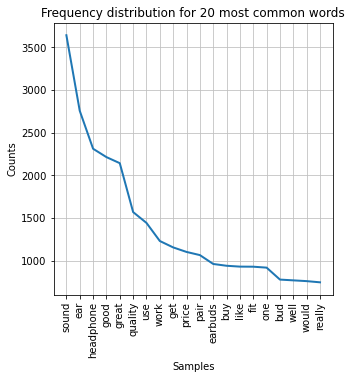

C:\Users\Sevde\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


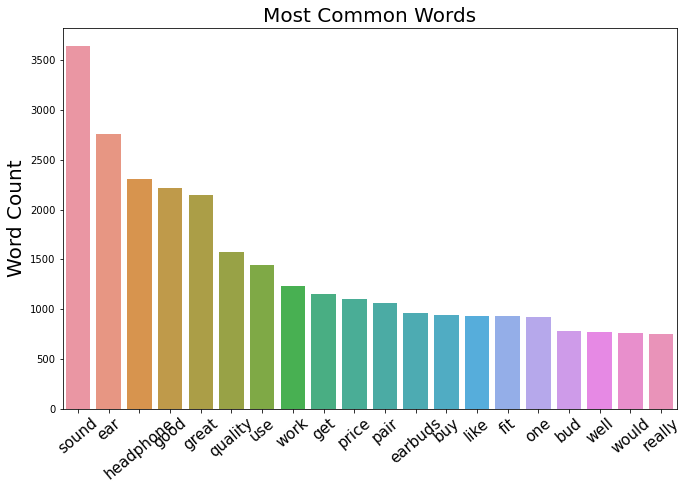

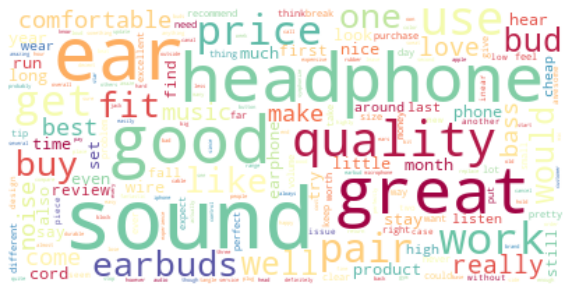

In [17]:
specific_words_to_remove = ["panasonic", "meelectronics", "nrg", "bose", "soundtrue"]
specific_adjectives_to_remove = []
cleaned_general = preprocess(product_df['review_body'], "general",specific_words_to_remove,specific_adjectives_to_remove)
product_df['general'] = cleaned_general
product_df['slight'] = preprocess(product_df['review_body'], "slight", specific_words_to_remove,specific_adjectives_to_remove)
review_ngram(cleaned_general, "unigram graphs", 1, 1)


<ipython-input-11-f21801fec193>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  process1 = ((re.sub(r'[`\-=~!@#$%^&*()_+\[\]{};\\\:"|<,./<>?]',"", review)) for review in tqdm(process0))


C:\Users\Sevde\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


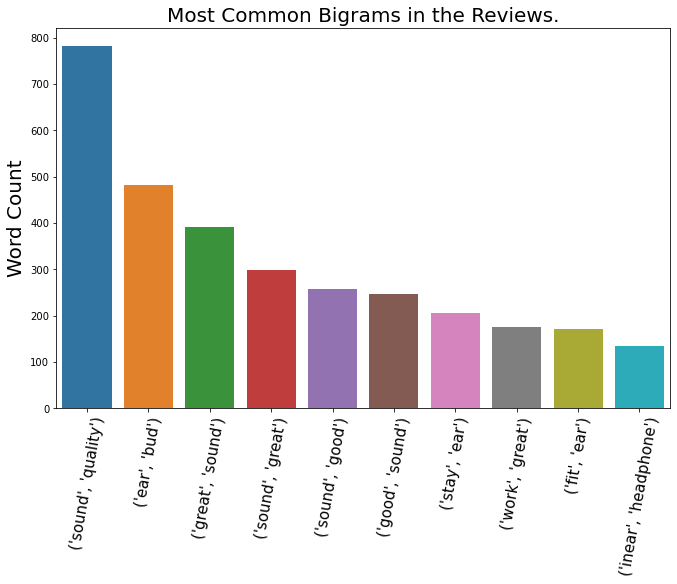

In [18]:
specific_words_to_remove = ["panasonic", "meelectronics", "nrg", "bose", "soundtrue"]


cleaned = preprocess(product_df['review_body'], "general",specific_words_to_remove, [])
review_ngram(cleaned, "bigram graphs", 2, 2)


In [19]:
product_df.reset_index(inplace=True, drop=True)


In [ ]:
###Scatter Text Plot

import pytextrank, spacy
import scattertext as st
from IPython.core.display import display, HTML


nlp = spacy.load('en_core_web_sm')



corpus = st.CorpusFromPandas(
    product_df, category_col="sentiment", text_col="general", nlp=nlp
).build()

html = st.produce_scattertext_explorer(
    corpus,
    category="1",
    category_name="Positive",
    not_category_name="Negative",
    width_in_pixels=1000,
)





In [ ]:
#Export the plot
#open("Scattertext.html", "wb").write(html.encode("utf-8"))

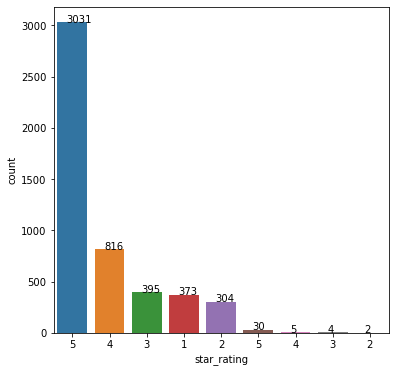

In [20]:
##Rating Distribution
plt.figure(figsize=(6,6))
ax = sns.countplot(x=product_df["star_rating"],  data=product_df, order = product_df["star_rating"].value_counts().index )
for p, label in zip(ax.patches, product_df["star_rating"].value_counts()):   
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.5))

<AxesSubplot:xlabel='polarity', ylabel='Count'>

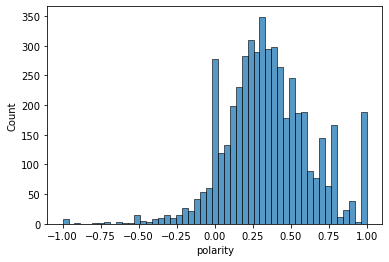

In [21]:
###Polarity distribution
sns.histplot(data=product_df, x="polarity")


# Training Dataset

In [22]:
##Sentence Count
sentence_count =review_sentence_count(deceptive_df['raw_review'])

print("Average sentence count of deceptive dataset", sum(sentence_count)/len(sentence_count))

print("Max sentence count:", max(sentence_count))


Average sentence count of deceptive dataset 8.4405
Max sentence count: 68


In [23]:
#Word counts
word_counts = review_length(deceptive_df['raw_review'])
print("Average word count of deceptive review corpus is", sum(word_counts)/len(word_counts))
print("Max review length:", max(word_counts))



Average word count of deceptive review corpus is 115.6743
Max review length: 922


In [24]:
#Average Word length

avg_word_length = review_avg_word_length(deceptive_df['raw_review'])

print("Average word length of deceptive review corpus is", sum(avg_word_length)/len(avg_word_length))

Average word length of deceptive review corpus is 3.691363496405029


<ipython-input-11-f21801fec193>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  process1 = ((re.sub(r'[`\-=~!@#$%^&*()_+\[\]{};\\\:"|<,./<>?]',"", review)) for review in tqdm(process0))


<ipython-input-11-f21801fec193>:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  process1 = ((re.sub("[\d-]", "", review)) for review in tqdm(process0))


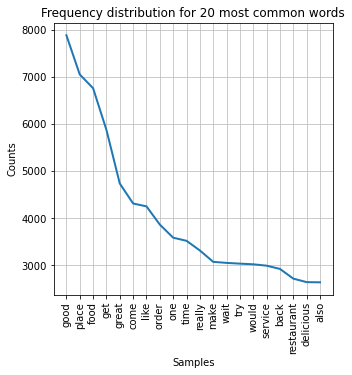

C:\Users\Sevde\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


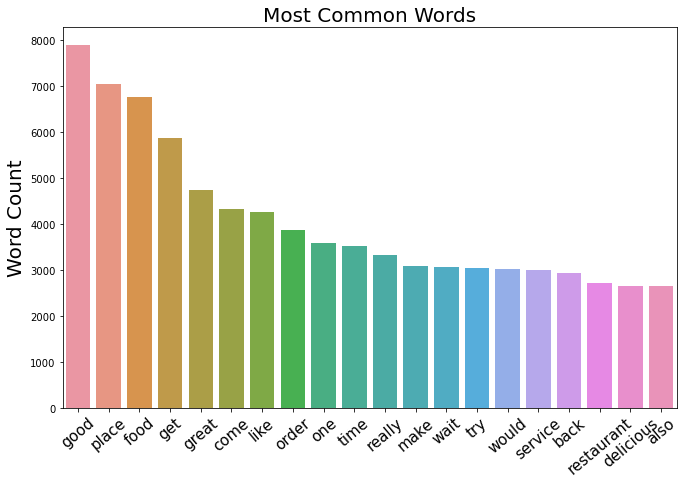

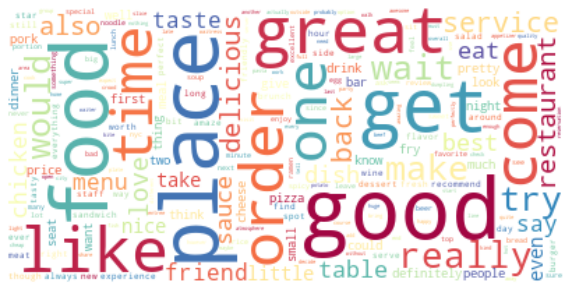

In [25]:
#N-gram features
dec_df = deceptive_df.copy()
specific_words_to_remove = []
specific_adjectives_to_remove = []
cleaned_general = preprocess(dec_df['raw_review'], "general",specific_words_to_remove,specific_adjectives_to_remove)
dec_df['general'] = cleaned_general
dec_df['slight'] = preprocess(dec_df['raw_review'], "slight", specific_words_to_remove,specific_adjectives_to_remove)
review_ngram(cleaned_general, "unigram graphs", 1, 1)

<ipython-input-11-f21801fec193>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  process1 = ((re.sub(r'[`\-=~!@#$%^&*()_+\[\]{};\\\:"|<,./<>?]',"", review)) for review in tqdm(process0))


C:\Users\Sevde\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


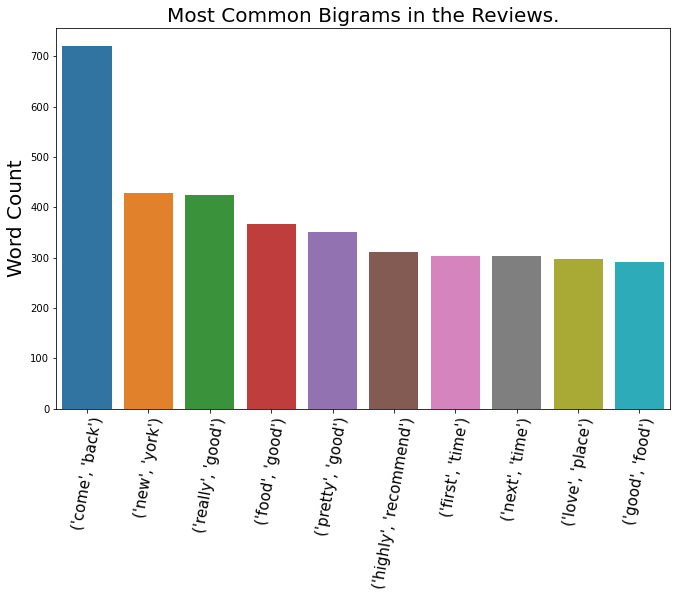

In [26]:
##Bigrams

specific_words_to_remove = []

cleaned = preprocess(deceptive_df['raw_review'], "general",specific_words_to_remove, [])
review_ngram(cleaned, "bigram graphs", 2, 2)


# FAKE REVIEW DETECTION

In [27]:
#PREPROCESS THE TRAINING DATA

#Elimination of repeated reviews
deceptive_df.drop_duplicates(subset ="raw_review",keep = False, inplace = True)
deceptive_df.reset_index(drop = True, inplace=True)
print("After eliminating repeated reviews deceptive_df:", deceptive_df.shape)

print()

#Elimination of short/simple reviews
deceptive_df = deceptive_df[deceptive_df['raw_review'].map(lambda x: len(str(x).split())) > 10 ]
deceptive_df.reset_index(drop = True, inplace = True)
print("After eliminating short/simple reviews deceptive_df:", deceptive_df.shape)


After eliminating repeated reviews deceptive_df: (10000, 7)

After eliminating short/simple reviews deceptive_df: (9669, 7)


# TRAINING

In [28]:
###PREPROCESS THE REVIEWS FOR THE FAKE REVIEW DETECTION

specific_words_to_remove = ["panasonic", "meelectronics", "nrg", "bose", "soundtrue"]
deceptive_df['slight']= preprocess(deceptive_df['raw_review'], 'slight', specific_words_to_remove, [])
deceptive_df['general']= preprocess(deceptive_df['raw_review'], 'general', [], [])

<ipython-input-11-f21801fec193>:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  process1 = ((re.sub("[\d-]", "", review)) for review in tqdm(process0))


<ipython-input-11-f21801fec193>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  process1 = ((re.sub(r'[`\-=~!@#$%^&*()_+\[\]{};\\\:"|<,./<>?]',"", review)) for review in tqdm(process0))


In [29]:
deceptive_df.shape

(9669, 9)

In [30]:
###FEATURE ENGINEERING

###Get all review centric and user centric features

x_df = pd.DataFrame()
x_df['review_avg_word_length'] = review_avg_word_length(deceptive_df['raw_review'])
x_df['review_capital_count'] = review_capital_count(deceptive_df['raw_review'])#
x_df['review_length'] = review_length(deceptive_df['raw_review'])
x_df['review_punctuation_count'] = review_punctuation_count(deceptive_df['raw_review'])#
x_df['review_sentence_count'] = review_sentence_count(deceptive_df['slight'])#
#x_df['user_avg_review_length'] = user_avg_review_length('raw_review')
#x_df['user_max_daily_reviews']= user_max_daily_reviews()

##Get postag percentages features

##Getting pos tag percentages
postag_df = review_postag_percentage(deceptive_df['slight'])

#postag_df to sparse
#postag_sparse = scipy.sparse.csr_matrix(postag_df.values)

#x_df = pd.concat([x_df, postag_df], axis = 1)


#Add the dependent variable- deceptive labels
x_df['label'] = deceptive_df['label']

<ipython-input-12-4badf95e3a22>:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tagged_review in tqdm(tagged_reviews):


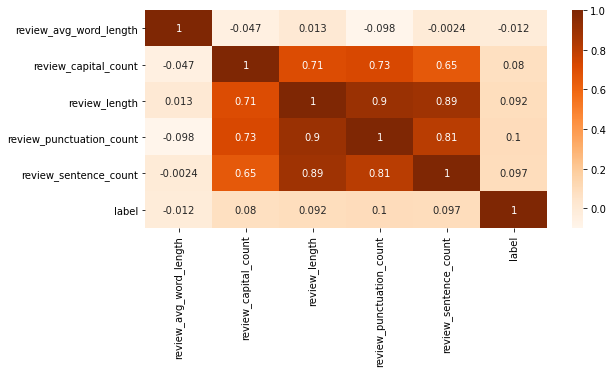

In [31]:
#CHECKING THE CORRELATION BETWEEN THE FEATURES EXTRACTED
plt.figure(figsize=(9,4))
#cor = x_df[['review_avg_word_length','review_capital_count', 'review_length','review_punctuation_count','review_sentence_count', 'label']].corr()
cor = x_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Oranges )
plt.show()

In [32]:
x_df = x_df.drop(['review_length', 'review_avg_word_length', 'review_sentence_count'], axis = 1)

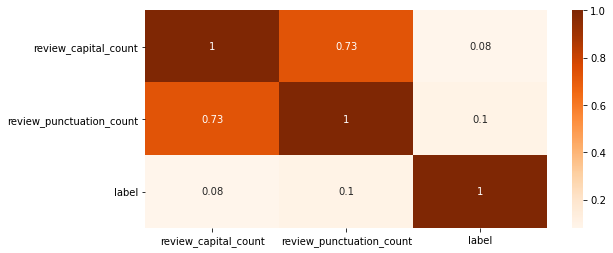

In [33]:
#CHECKING THE CORRELATION BETWEEN THE FEATURES EXTRACTED
plt.figure(figsize=(9,4))
cor = x_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Oranges )
plt.show()

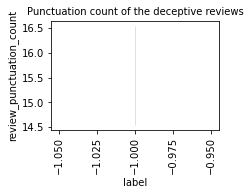

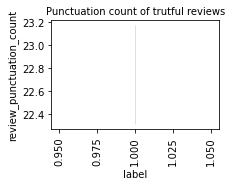

In [34]:
#Being deceptive and punctuation count
fig, ax = plt.subplots(figsize=(3,2)) 
sns.lineplot(x= x_df[x_df['label'] == -1]['label'] , y= x_df[x_df['label'] == -1]['review_punctuation_count'])
plt.xticks(rotation=90);
plt.title("Punctuation count of the deceptive reviews", size=10);

#Being deceptive and punctuation count
fig, ax = plt.subplots(figsize=(3,2)) 
sns.lineplot(x= x_df[x_df['label'] == 1]['label'] , y= x_df[x_df['label'] == 1]['review_punctuation_count'])
plt.xticks(rotation=90);
plt.title("Punctuation count of trutful reviews", size=10);


# TRAINING AND TEST CORPUS

In [36]:
#Specifying training and test data
from sklearn.model_selection import train_test_split

y = x_df['label']
X = x_df.drop(columns = ['label'], axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# RANDOM FOREST

In [37]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


rfc_cv_score1 = cross_val_score(rfc, X, y, cv=5, scoring='f1_macro')
rfc_cv_score2 = cross_val_score(rfc, X, y, cv=5, scoring='accuracy')


In [39]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
#print("=== All Scores ===")
#print(rfc_cv_score)
print('\n')
print("=== Mean Score Cross Validation ===")
print("Mean Score - Random Forest: ", "f1 score:", rfc_cv_score1.mean(), " accuracy:", rfc_cv_score2.mean())

=== Confusion Matrix ===
[[   2  286]
 [  40 2863]]


=== Classification Report ===
              precision    recall  f1-score   support

          -1       0.05      0.01      0.01       288
           1       0.91      0.99      0.95      2903

    accuracy                           0.90      3191
   macro avg       0.48      0.50      0.48      3191
weighted avg       0.83      0.90      0.86      3191





=== Mean Score Cross Validation ===
Mean Score - Random Forest:  f1 score: 0.4823341434232872  accuracy: 0.8955419693121858


# SUPPORT VECTOR MACHINES

In [40]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train,y_train)
# predictions
svc_predict = svc.predict(X_test)


In [41]:
svc_cv_score1 = cross_val_score(svc, X, y, cv=5, scoring='f1_macro')
svc_cv_score2 = cross_val_score(svc, X, y, cv=5, scoring='accuracy')

In [42]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, svc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, svc_predict))
print('\n')
#print("=== All  Scores ===")
#print(svc_cv_score)
print('\n')
print("=== Mean  Score Cross Validation ===")
print("Mean Score - SVM: ","f1 macro:", svc_cv_score1.mean(), " accuracy:", svc_cv_score2.mean() )




=== Confusion Matrix ===
[[   0  288]
 [   0 2903]]


=== Classification Report ===
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       288
           1       0.91      1.00      0.95      2903

    accuracy                           0.91      3191
   macro avg       0.45      0.50      0.48      3191
weighted avg       0.83      0.91      0.87      3191





=== Mean  Score Cross Validation ===
Mean Score - SVM:  f1 macro: 0.47510992491366455  accuracy: 0.9051608405899602


C:\Users\Sevde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# NAIVE BAYES

In [43]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_pred  =  nb.predict(X_test)

In [44]:
nb_cv_score1 = cross_val_score(nb, X, y, cv=5, scoring='f1_macro')
nb_cv_score2 = cross_val_score(nb, X, y, cv=5, scoring='accuracy')


In [45]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, nb_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, nb_pred))
print('\n')
#print("=== All Scores ===")
#print(nb_cv_score)
print('\n')
print("=== Mean Score Cross Validation ===")
print("Mean Score - Naive Bayes: ", "f1 score:", nb_cv_score1.mean(), " accuracy:", nb_cv_score2.mean())

=== Confusion Matrix ===
[[   0  288]
 [   0 2903]]


=== Classification Report ===
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       288
           1       0.91      1.00      0.95      2903

    accuracy                           0.91      3191
   macro avg       0.45      0.50      0.48      3191
weighted avg       0.83      0.91      0.87      3191





=== Mean Score Cross Validation ===
Mean Score - Naive Bayes:  f1 score: 0.47510992491366455  accuracy: 0.9051608405899602


C:\Users\Sevde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TRAINING WITH BIGRAMS 

In [46]:
##Getting bigram-unigram features

import scipy.sparse
from scipy.sparse import csr_matrix

bigram_tfidf = review_ngram(deceptive_df['general'],  "ngram", 1,2) #in sparse form
bigrams = bigram_tfidf[0] #also includes unigrams in it
labels = deceptive_df['label']




In [47]:
bigrams

<9669x344799 sparse matrix of type '<class 'numpy.float64'>'
	with 1024461 stored elements in Compressed Sparse Row format>

In [48]:
from scipy.sparse import hstack

X = bigrams #includes unigrams as well, #hstack((bigrams, postag_sparse))
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean = False)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [49]:
classifiers = [RandomForestClassifier(), SVC(), GaussianNB()]

In [50]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

numFeatures = np.linspace(500, 5000, 5)#(500, 2500,5)
bestNofFeatures = None
best_f1_score = 0.0
best_feature_numbers = []
for classifier in classifiers:
    for n_feat in numFeatures:
        # select features
        selector = SelectKBest(chi2, k=int(n_feat)).fit(X, y)
        X_sel = selector.transform(X)
        cv_reg = cross_val_score(classifier, X_sel, y=y, cv=5, scoring="f1_macro").mean()

        if cv_reg > best_f1_score:
            best_f1_score = cv_reg
            bestNofFeatures = X_sel.shape[1]
            
    best_feature_numbers.append(bestNofFeatures)
    print("best number of features for {} is {}".format(classifier, bestNofFeatures))




best number of features for RandomForestClassifier() is 1625
best number of features for SVC() is 5000


C:\Users\Sevde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sevde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sevde\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 210, in fit
    X, y = self._validate_data(X, y)
  File "C:\Users\Sevde\anaconda3\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\Sevde\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\Sevde\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 795, in check_X_y
    X = check_array(X, accept_sparse=accept_sparse,
  File "C:\Users\Sevde\anaco

best number of features for GaussianNB() is 5000


C:\Users\Sevde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Sevde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sevde\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 210, in fit
    X, y = self._validate_data(X, y)
  File "C:\Users\Sevde\anaconda3\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\Sevde\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\Sevde\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 795, in check_X_y
    X = check_array(X, accept_sparse=accept_sparse,
  File "C:\Users\Sevde\anaco

In [51]:
best_feature_numbers

[1625, 5000, 5000]

# Results

In [52]:
####Random Forest

##Applying the chosen number of features

X=bigrams #includes unigrams in it as well

selector = SelectKBest(chi2, k=best_feature_numbers[0]).fit(X, y)
X = selector.transform(X)
y = labels


####################Combine features####
from scipy.sparse import hstack
#x_df.drop(['label'], axis=1, inplace=True)
combined = pd.concat([pd.DataFrame.sparse.from_spmatrix(X), postag_df ], axis =1)
all_features_to_reduce = scipy.sparse.csr_matrix(combined)
y = deceptive_df['label']
X = all_features_to_reduce
###################################
#Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

sc = StandardScaler(with_mean = False)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


#Fitting the traning data
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

#Cross validation
rfc_cv_score1 = cross_val_score(rfc, X, y, cv=5, scoring='f1_macro')
rfc_cv_score2 = cross_val_score(rfc, X, y, cv=5, scoring='accuracy')

##Results

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
#print("=== All Scores ===")
#print(rfc_cv_score)
print('\n')
print("=== Mean Score Cross Validation ===")
print("Mean Score - Random Forest: ", "f1 score:", rfc_cv_score1.mean(), " accuracy:", rfc_cv_score2.mean())

=== Confusion Matrix ===
[[   0  288]
 [   0 2903]]


=== Classification Report ===
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       288
           1       0.91      1.00      0.95      2903

    accuracy                           0.91      3191
   macro avg       0.45      0.50      0.48      3191
weighted avg       0.83      0.91      0.87      3191





=== Mean Score Cross Validation ===
Mean Score - Random Forest:  f1 score: 0.4750814170203389  accuracy: 0.9051608405899602


C:\Users\Sevde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
####Support Vector Machines



##Loading the data again

X = bigrams #includes unigrams in it as well
y = labels

##Applying the chosen number of features

selector = SelectKBest(chi2, k=best_feature_numbers[1]).fit(X, y)
X = selector.transform(X)
y = labels

####################Combine features####
from scipy.sparse import hstack
#x_df.drop(['label', 'raw_review'], axis=1, inplace=True)
combined = pd.concat([pd.DataFrame.sparse.from_spmatrix(X), postag_df ], axis =1)
all_features_to_reduce = scipy.sparse.csr_matrix(combined)
y = deceptive_df['label']
X = all_features_to_reduce
###################################
#Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

sc = StandardScaler(with_mean = False)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#Fitting the traning data
svc = SVC()
svc.fit(X_train,y_train)
# predictions
svc_predict = svc.predict(X_test)

#Cross validation
svc_cv_score1 = cross_val_score(svc, X, y, cv=5, scoring='f1_macro')
svc_cv_score2 = cross_val_score(svc, X, y, cv=5, scoring='accuracy')

##Results
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, svc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, svc_predict))
print('\n')
#print("=== All  Scores ===")
#print(svc_cv_score)
print('\n')
print("=== Mean  Score Cross Validation ===")
print("Mean Score - SVC: ","f1 macro:", svc_cv_score1.mean(), " accuracy:", svc_cv_score2.mean() )




=== Confusion Matrix ===
[[ 134  154]
 [  19 2884]]


=== Classification Report ===
              precision    recall  f1-score   support

          -1       0.88      0.47      0.61       288
           1       0.95      0.99      0.97      2903

    accuracy                           0.95      3191
   macro avg       0.91      0.73      0.79      3191
weighted avg       0.94      0.95      0.94      3191





=== Mean  Score Cross Validation ===
Mean Score - SVC:  f1 macro: 0.8740159674141186  accuracy: 0.9642157038450982


In [54]:
####Naive Bayes Classifier


##Loading the data again

X = bigrams #includes unigrams in it as well
y = labels



##Applying the chosen number of features

selector = SelectKBest(chi2, k=best_feature_numbers[2]).fit(X, y)
X = selector.transform(X)
y = labels

####################Combine features####
from scipy.sparse import hstack
#x_df.drop(['label', 'raw_review'], axis=1, inplace=True)
combined = pd.concat([pd.DataFrame.sparse.from_spmatrix(X), postag_df ], axis =1)
all_features_to_reduce = scipy.sparse.csr_matrix(combined)
y = deceptive_df['label']
X = all_features_to_reduce
###################################

##Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

sc = StandardScaler(with_mean = False)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


#Fitting the traning data
nb = GaussianNB()
nb.fit(X_train.toarray(),y_train)
# predictions
nb_predict = nb.predict(X_test.toarray())

#Cross validation
nb_cv_score1 = cross_val_score(nb, X.toarray(), y, cv=5, scoring='f1_macro')
nb_cv_score2 = cross_val_score(nb, X.toarray(), y, cv=5, scoring='accuracy')

##Results
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, nb_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, nb_pred))
print('\n')
#print("=== All Scores ===")
#print(nb_cv_score)
print('\n')
print("=== Mean Score Cross Validation ===")
print("Mean Score - Naive Bayes: ", "f1 score:", nb_cv_score1.mean(), " accuracy:", nb_cv_score2.mean())

=== Confusion Matrix ===
[[   0  288]
 [   0 2903]]


=== Classification Report ===
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       288
           1       0.91      1.00      0.95      2903

    accuracy                           0.91      3191
   macro avg       0.45      0.50      0.48      3191
weighted avg       0.83      0.91      0.87      3191





=== Mean Score Cross Validation ===
Mean Score - Naive Bayes:  f1 score: 0.6372421697089582  accuracy: 0.8971982296273667


C:\Users\Sevde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# FAKE REVIEW PREDICTION USING PRODUCT CORPUS

In [55]:
####Support Vector Machines
import scipy.sparse
##Loading the data again

features_dataframe = pd.DataFrame.sparse.from_spmatrix(bigrams)
targeted_class = labels

##Applying the chosen number of features


select_k_best_classifier = SelectKBest(score_func=chi2, k=best_feature_numbers[1]).fit(features_dataframe, targeted_class)
cols = select_k_best_classifier.get_support()
# Get columns to keep and create new dataframe with those only
X_selected = features_dataframe[features_dataframe.columns[cols]]
y = labels


In [56]:
####################Combine features####
from scipy.sparse import hstack
#x_df.drop(['label'], axis=1, inplace=True)
combined = pd.concat([X_selected, postag_df ], axis =1)
all_features_to_reduce = scipy.sparse.csr_matrix(combined)
y = deceptive_df['label']
X = all_features_to_reduce
###################################


In [57]:

#Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

sc = StandardScaler(with_mean = False)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)




In [58]:
#SVC


##Fitting the traning data
svc = SVC()
svc.fit(X_train,y_train)
# predictions
svc_predict = svc.predict(X_test)

#Cross validation
svc_cv_score1 = cross_val_score(svc, X, y, cv=5, scoring='f1_macro')
svc_cv_score2 = cross_val_score(svc, X, y, cv=5, scoring='accuracy')

##Results
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, svc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, svc_predict))
print('\n')
#print("=== All  Scores ===")
#print(svc_cv_score)
print('\n')
print("=== Mean  Score Cross Validation ===")
print("Mean Score - SVC: ","f1 macro:", svc_cv_score1.mean(), " accuracy:", svc_cv_score2.mean() )




=== Confusion Matrix ===
[[ 134  154]
 [  19 2884]]


=== Classification Report ===
              precision    recall  f1-score   support

          -1       0.88      0.47      0.61       288
           1       0.95      0.99      0.97      2903

    accuracy                           0.95      3191
   macro avg       0.91      0.73      0.79      3191
weighted avg       0.94      0.95      0.94      3191





=== Mean  Score Cross Validation ===
Mean Score - SVC:  f1 macro: 0.8740159674141186  accuracy: 0.9642157038450982


# PREDICT IN PRODUCT CORPUS

In [59]:
##PREPROCESS THE PREDICTION DATA

#Elimination of repeated reviews
product_df.drop_duplicates(subset ="review_body",keep = False, inplace = True)
product_df.reset_index(drop = True, inplace=True)
print("After eliminating repeated reviews product_df:", product_df.shape)

print()

#Elimination of short/simple reviews
product_df = product_df[product_df['review_body'].map(lambda x: len(str(x).split())) > 10 ]
product_df.reset_index(drop = True, inplace = True)
print("After eliminating short/simple reviews product_df:", product_df.shape)


After eliminating repeated reviews product_df: (4780, 10)

After eliminating short/simple reviews product_df: (3612, 10)


In [60]:
###PREDICT
from sklearn.feature_extraction.text import TfidfVectorizer

##Get the selected feature names

selected_feature_indexes = X_selected.columns
feature_names = bigram_tfidf[1].get_feature_names()
selected_features = [feature_names[i] for i in selected_feature_indexes]


# Create new tfidfVectorizer with old vocabulary
tfidf_predict = TfidfVectorizer(analyzer='word', ngram_range=(1,2), stop_words = "english", lowercase = True
                          , vocabulary = selected_features)




In [61]:
bigrams_predict = tfidf_predict.fit_transform(product_df['general']) ##new corpus
##Includes unigrams as well

In [62]:
#x_df_predict = pd.DataFrame()
#x_df_predict['review_capital_count'] = review_capital_count(product_df['review_body'])#
#x_df_predict['review_punctuation_count'] = review_punctuation_count(product_df['review_body'])#
#x_df_predict['review_sentence_count'] = review_sentence_count(product_df['slight'])#



##Getting pos tag percentages
postag_df_predict = review_postag_percentage(product_df['slight'])

#postag_df to sparse
#postag_sparse = scipy.sparse.csr_matrix(postag_df.values)

#x_df_predict = pd.concat([x_df_predict, postag_df_predict], axis = 1)
x_df_predict = postag_df_predict



<ipython-input-12-4badf95e3a22>:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tagged_review in tqdm(tagged_reviews):


In [63]:
##Combine tfidf values of product reviews with other features

bigram_df_predict = pd.DataFrame.sparse.from_spmatrix(bigrams_predict)
combined_predict = pd.concat([bigram_df_predict, x_df_predict ], axis =1)


X_predict = sc.fit_transform(combined_predict)


#Fitting the traning data
svc = SVC()
svc.fit(X_train,y_train)

# predictions
svc_predict = svc.predict(X_predict)



C:\Users\Sevde\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Sevde\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [64]:
Counter(svc_predict)

Counter({1: 3545, -1: 67})

In [65]:
product_df['deceptive_prediction'] = svc_predict

In [66]:
product_df = product_df[product_df['deceptive_prediction'] == 1]

In [67]:
product_df.shape

(3545, 11)

# FEATURE AND EMOTION EXTRACTION

In [69]:
import stanza
import spacy
import nltk
from nltk.corpus import wordnet

## loading English package
stanza.download("en")

## Building the pipeline
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')


2021-09-23 14:22:56 INFO: Downloading default packages for language: en (English)...


2021-09-23 14:22:58 INFO: File exists: C:\Users\Sevde\stanza_resources\en\default.zip.
2021-09-23 14:23:03 INFO: Finished downloading models and saved to C:\Users\Sevde\stanza_resources.
2021-09-23 14:23:03 WARNING: Can not find mwt: default from official model list. Ignoring it.
2021-09-23 14:23:03 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2021-09-23 14:23:03 INFO: Use device: cpu
2021-09-23 14:23:03 INFO: Loading: tokenize
2021-09-23 14:23:03 INFO: Loading: pos
2021-09-23 14:23:03 INFO: Loading: lemma
2021-09-23 14:23:03 INFO: Loading: depparse
2021-09-23 14:23:04 INFO: Done loading processors!


# NEGATION HANDLING

In [70]:
def dependency_parser(reviews):
    relations_of_all_reviews = []
    for review in tqdm(reviews):
        doc = nlp(str(review))
        parsed_sentences = []
        for i, sentence in enumerate(doc.sentences):
            parsed_sentence = [((word.text, word.xpos),((sentence.words[word.head-1].text if word.head > 0 else "root"), (sentence.words[word.head-1].xpos)),(word.deprel)) for word in sentence.words]
            parsed_sentences.append(parsed_sentence)  

        all_relations = list(chain(*parsed_sentences))
        relations_of_all_reviews.append(all_relations)
        
    return relations_of_all_reviews

In [71]:
dependency_parser(["These little earbuds functions poorly but the material are durable"])

<ipython-input-70-e53fcc751c9a>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for review in tqdm(reviews):


[[(('These', 'DT'), ('functions', 'NNS'), 'det'),
  (('little', 'JJ'), ('functions', 'NNS'), 'amod'),
  (('earbuds', 'NNS'), ('functions', 'NNS'), 'compound'),
  (('functions', 'NNS'), ('root', 'JJ'), 'root'),
  (('poorly', 'RB'), ('functions', 'NNS'), 'advmod'),
  (('but', 'CC'), ('durable', 'JJ'), 'cc'),
  (('the', 'DT'), ('material', 'NN'), 'det'),
  (('material', 'NN'), ('durable', 'JJ'), 'nsubj'),
  (('are', 'VBP'), ('durable', 'JJ'), 'cop'),
  (('durable', 'JJ'), ('functions', 'NNS'), 'conj')]]

In [72]:
##THE LATEST NEGATION HANDLING

def negation_handler(reviews, syntactic_relations):
    handled_reviews = []
    for i in range(len(reviews)):
        negation_check = [1 for relation in syntactic_relations[i] if relation[2] == "advmod" and  ("n't" == relation[0][0] or "not" == relation[0][0]) ]

        if sum(negation_check) > 0:
            try:
                for relation in syntactic_relations[i]:

                    if relation[2] == "advmod" and  ("n't" == relation[0][0] or "not" == relation[0][0]):
                        if relation[1][1] == "JJ": 
                            tokenized = word_tokenize(reviews[i])
                            word_index = tokenized.index(relation[1][0])

                            if "too" == tokenized[word_index -1] or "very" == tokenized[word_index -1] or "so" == tokenized[word_index -1]: #(e.g This is not too bad ----> This good)
                                antonym = str(wn.synset(relation[1][0]+'.a.01').lemmas()[0].antonyms()[0])
                                antonym = antonym.strip("Lemma").strip("('").split(".")[0]
                                tokenized[word_index] = antonym
                                tokenized.pop(word_index-1)
                                tokenized.pop(word_index-2)
                                reviews[i] = " ".join(tokenized)

                            else:
                                antonym = str(wn.synset(relation[1][0]+'.a.01').lemmas()[0].antonyms()[0])
                                antonym = antonym.strip("Lemma").strip("('").split(".")[0]
                                tokenized[word_index] = antonym
                                tokenized.pop(word_index-1)
                                reviews[i] = " ".join(tokenized)

                        if relation[1][1] == "VB":
                            if relation[1][0] == "like":
                                tokenized = word_tokenize(reviews[i])
                                word_index = tokenized.index(relation[1][0])
                                antonym = "dislike"
                                tokenized[word_index] = antonym
                                tokenized.pop(word_index-1)
                                reviews[i] = " ".join(tokenized)

                            else:
                                tokenized = word_tokenize(reviews[i])
                                word_index = tokenized.index(relation[1][0])
                                antonym = str(wn.synset(relation[1][0]+'.v.01').lemmas()[0].antonyms()[0])
                                antonym = antonym.strip("Lemma").strip("('").split(".")[0]
                                tokenized[word_index] = antonym
                                tokenized.pop(word_index-1)
                                reviews[i] = " ".join(tokenized)

                        if relation[1][1] == "NN":
                            tokenized = word_tokenize(reviews[i])
                            noun_index = tokenized.index(relation[1][0])
                            adjective = tokenized[noun_index-1]
                            neg_aux_index = tokenized.index(relation[0][0])

                            antonym = str(wn.synset(adjective+'.a.01').lemmas()[0].antonyms()[0])
                            antonym = antonym.strip("Lemma").strip("('").split(".")[0]
                            tokenized[noun_index-1] = antonym
                            tokenized.pop(neg_aux_index)
                            reviews[i] = " ".join(tokenized)

                handled_reviews.append(reviews[i])
            except:
                handled_reviews.append(reviews[i])

        else:
            handled_reviews.append(reviews[i])
            
    return handled_reviews

          


In [73]:

##Slight preprocessing of the review for feature extraction

specific_words_to_remove = ["panasonic", "meelectronics", "nrg", "bose", "soundtrue"]
specific_adjectives_to_remove = ["good", "great", "nice"]

product_df['slight'] = preprocess(product_df['review_body'], 'slight', specific_words_to_remove, specific_adjectives_to_remove)
product_df.reset_index(drop=True, inplace=True)


<ipython-input-11-f21801fec193>:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  process1 = ((re.sub("[\d-]", "", review)) for review in tqdm(process0))


In [74]:
##Adding the syntactic relationf of each review in the dataframe

product_df['syntactic_relations'] = dependency_parser(product_df['slight'])


<ipython-input-70-e53fcc751c9a>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for review in tqdm(reviews):


In [75]:
#handling product reviews
product_df['handled_review'] = negation_handler(product_df['slight'], product_df['syntactic_relations'])

<ipython-input-72-d4ece2e0b425>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews[i] = " ".join(tokenized)
<ipython-input-72-d4ece2e0b425>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews[i] = " ".join(tokenized)
<ipython-input-72-d4ece2e0b425>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews[i] = " ".join(tokenized)
<ipython-input-72-d4ece2e0b425>:60: SettingWithCopyWarning: 
A value is trying to be set on a 

# KANSEI KNOWLEDGE EXTRACTION

In [283]:
####Tranform verbs into noun form
lemmatizer = nltk.WordNetLemmatizer()

def nounify(verb_word):
    from pyinflect import getInflection
    neutral = lemmatizer.lemmatize(verb_word, pos = "v")

    return getInflection(neutral,'VBG')[0]

# NOUN AND ADJECTIVE EXTRACTION

In [77]:
words = set(nltk.corpus.words.words())
stop_words = stopwords.words('english')

In [306]:
def extract_nouns_and_adjectives(reviews):
    adjectives = []
    nouns = []
    for review in tqdm(reviews):
        postagged = nltk.pos_tag(word_tokenize(review))
        for element in postagged:
            if element[1] == "JJ":
                if element[0] != "i"  and (element[0] not in ["much", "very", "too", "ear", "little"] + stop_words)  and (lemmatizer.lemmatize(element[0], pos = "a") in words):
                    adjectives.append(element[0])
                
            if element[1] == "NN":
                if element[0] != "i" and (element[0] != ".." )  and (element[0] not in stop_words)  and (lemmatizer.lemmatize(element[0], pos = "n") in words):
                    if element[0] == "mic":
                        element[0] == "microphone"
                        nouns.append(element[0])
                    else:
                        nouns.append(element[0])
                
    return {"nouns": nouns, "adjectives": adjectives}
                
    
    

In [307]:
###Nouns and adjectives in the cleaned corpus
noun_adj_dict =  extract_nouns_and_adjectives(product_df['slight'])

<ipython-input-306-ae3d944b0f0c>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for review in tqdm(reviews):


In [308]:
Counter(noun_adj_dict['adjectives']+noun_adj_dict['nouns']).most_common()

[('sound', 2688),
 ('headphone', 1997),
 ('quality', 1376),
 ('ear', 1364),
 ('pair', 974),
 ('price', 908),
 ('bud', 796),
 ('work', 639),
 ('bass', 568),
 ('noise', 552),
 ('music', 496),
 ('comfortable', 493),
 ('time', 490),
 ('use', 485),
 ('earphone', 479),
 ('cord', 448),
 ('fit', 441),
 ('product', 436),
 ('month', 429),
 ('wire', 415),
 ('phone', 397),
 ('year', 359),
 ('last', 320),
 ('high', 318),
 ('volume', 293),
 ('thing', 289),
 ('review', 286),
 ('size', 277),
 ('day', 274),
 ('cheap', 272),
 ('first', 262),
 ('set', 255),
 ('clear', 254),
 ('lot', 252),
 ('small', 233),
 ('different', 225),
 ('way', 225),
 ('purchase', 221),
 ('run', 219),
 ('problem', 215),
 ('right', 204),
 ('new', 201),
 ('long', 200),
 ('tip', 199),
 ('piece', 193),
 ('issue', 193),
 ('excellent', 190),
 ('look', 188),
 ('case', 187),
 ('money', 184),
 ('low', 178),
 ('design', 173),
 ('gym', 172),
 ('something', 170),
 ('bit', 169),
 ('week', 163),
 ('control', 160),
 ('perfect', 159),
 ('cable', 

In [309]:
###Getting the most frequent ones
len(Counter(noun_adj_dict['adjectives']+noun_adj_dict['nouns']).most_common())


3588

# SYNTACTIC EXTRACTION(DEPENDENCY PARSING BASED)

In [310]:
words = set(nltk.corpus.words.words())
stop_words = stopwords.words('english')

In [439]:
def syntactic_extraction(reviews, syntactic_relations):
    features = []
    kanseis = [] 
    
    for review_relation in tqdm(syntactic_relations):
        for relation in review_relation:

            if relation[2] == "amod":
                if relation[0][1] == "JJ" and  (relation[0][0] not in ["much", "very", "too", "ear", "little"] + stop_words) and (lemmatizer.lemmatize(relation[0][0], pos = "a") in words ): 
                    kanseis.append(relation[0][0])
                if relation[1][1] == "NN" and ( relation[1][0] not in stop_words) and (lemmatizer.lemmatize(relation[1][0], pos = "n") in words):
                    features.append(relation[1][0])

            if relation[2] == "nsubj":
                if relation[1][1] == "JJ" and (relation[1][0] not in ["much", "very", "too", "ear", "little"] +stop_words) and lemmatizer.lemmatize(relation[1][0], pos = "a") in words:
                    kanseis.append(relation[1][0])
                if relation[0][1] == "NN"and (relation[0][0] not in stop_words) and (lemmatizer.lemmatize(relation[0][0], pos = "n") in words):
                    features.append(relation[0][0])
            
            if relation[2] == "advmod" and relation[1][1] == "VBZ" : 
                    if relation[0][1] == "RB"  and ( relation[0][0] not in ["much", "very", "too", "ear", "little", "usually", "always", "either", "neither", "personally", "quitely", "rarely", "always", "importantly"]+stop_words) and (lemmatizer.lemmatize(relation[0][0], pos = "r") in words ) :
                        kanseis.append(relation[0][0])
                    if relation[1][1] == "VBZ" and ( relation[1][0] not in stop_words) and (lemmatizer.lemmatize(relation[1][0], pos = "v") in words):
                        features.append(relation[1][0])
                        #try:
                            #features.append(nounify(relation[1][0]))
                        #except:
                            #features.append(relation[1][0])
                    


                
    return {"features": features, "kanseis": kanseis}
                
        

In [440]:
##GETTING KANSEIS AND FEATURES
feature_kansei_dict = syntactic_extraction(product_df['slight'], product_df['syntactic_relations'])

<ipython-input-439-96918bf6ee1f>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for review_relation in tqdm(syntactic_relations):


# KANSEIS

In [441]:
features = feature_kansei_dict['features']
kanseis = feature_kansei_dict['kanseis']

In [442]:
Counter(kanseis).most_common()

[('comfortable', 320),
 ('cheap', 243),
 ('high', 224),
 ('different', 221),
 ('small', 207),
 ('first', 203),
 ('new', 191),
 ('clear', 177),
 ('excellent', 170),
 ('right', 155),
 ('long', 151),
 ('awesome', 139),
 ('low', 135),
 ('perfect', 130),
 ('many', 126),
 ('decent', 125),
 ('old', 116),
 ('expensive', 112),
 ('happy', 106),
 ('second', 105),
 ('last', 102),
 ('bad', 100),
 ('worth', 95),
 ('big', 93),
 ('several', 92),
 ('fantastic', 87),
 ('left', 87),
 ('amazing', 83),
 ('quality', 78),
 ('loud', 78),
 ('hard', 78),
 ('extra', 75),
 ('outside', 62),
 ('crisp', 61),
 ('durable', 61),
 ('able', 59),
 ('else', 59),
 ('full', 57),
 ('heavy', 56),
 ('sure', 54),
 ('short', 54),
 ('plastic', 52),
 ('deep', 47),
 ('enough', 46),
 ('previous', 46),
 ('rich', 45),
 ('fine', 45),
 ('multiple', 45),
 ('inexpensive', 44),
 ('solid', 44),
 ('large', 44),
 ('disappointed', 44),
 ('audiophile', 43),
 ('nylon', 43),
 ('standard', 40),
 ('easy', 40),
 ('terrible', 39),
 ('original', 38),
 

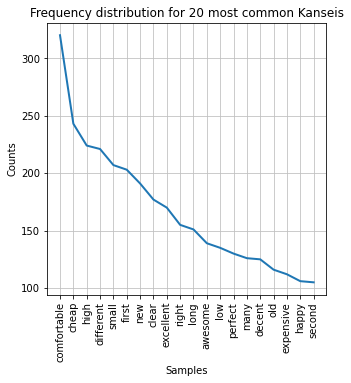

C:\Users\Sevde\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


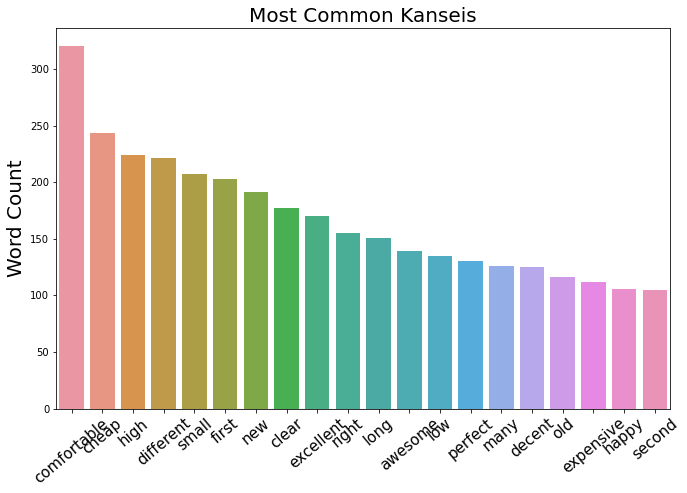

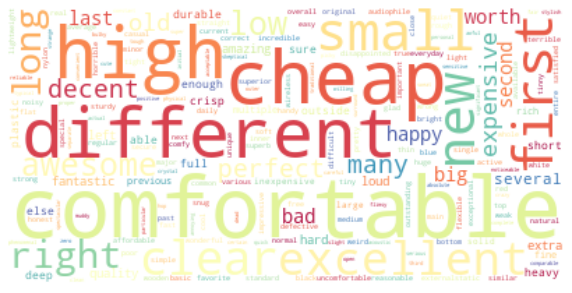

In [443]:
#Frequency Distribution
fdist = FreqDist(kanseis)

#FDist Line Graph
plt.figure(figsize = (5,5))
fdist.plot(20, title = "Frequency distribution for 20 most common Kanseis")

most_common_words = [x[0] for x in fdist.most_common(20)]
counts = [x[1] for x in fdist.most_common(20)]
plt.figure(figsize=(11,7))
plot = sns.barplot(np.arange(20), counts) #width = 0.35)
plt.ylabel("Word Count", fontsize = 20)
plt.xticks(np.arange(20), most_common_words, fontsize=15, rotation=40)
plt.title("Most Common Kanseis", fontsize = 20)
plt.show()

#Word cloud
cloud = WordCloud(max_font_size=60,background_color='white', colormap = 'Spectral').generate_from_frequencies(fdist)
plt.figure(figsize=(10,10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# FEATURES

In [444]:
Counter(features).most_common()

[('sound', 1038),
 ('headphone', 1018),
 ('quality', 714),
 ('pair', 564),
 ('bud', 420),
 ('cord', 306),
 ('bass', 291),
 ('thing', 279),
 ('ear', 255),
 ('earphone', 253),
 ('one', 217),
 ('wire', 217),
 ('time', 205),
 ('noise', 197),
 ('price', 191),
 ('product', 165),
 ('size', 156),
 ('set', 151),
 ('fit', 151),
 ('review', 143),
 ('piece', 136),
 ('tip', 132),
 ('phone', 111),
 ('design', 102),
 ('case', 96),
 ('cable', 93),
 ('month', 92),
 ('problem', 92),
 ('music', 90),
 ('use', 89),
 ('issue', 88),
 ('color', 81),
 ('volume', 73),
 ('complaint', 71),
 ('part', 70),
 ('side', 69),
 ('year', 68),
 ('work', 66),
 ('day', 62),
 ('brand', 61),
 ('control', 61),
 ('button', 59),
 ('something', 57),
 ('reason', 57),
 ('model', 53),
 ('end', 53),
 ('range', 51),
 ('nothing', 49),
 ('plug', 48),
 ('amount', 48),
 ('look', 45),
 ('anything', 43),
 ('way', 42),
 ('jack', 42),
 ('experience', 42),
 ('service', 42),
 ('week', 41),
 ('material', 40),
 ('speaker', 40),
 ('wood', 40),
 ('h

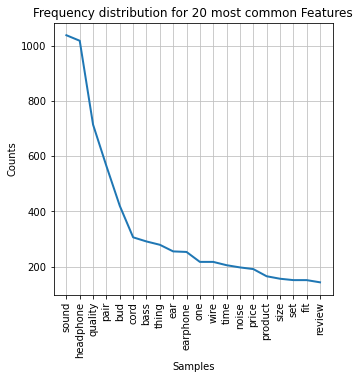

C:\Users\Sevde\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


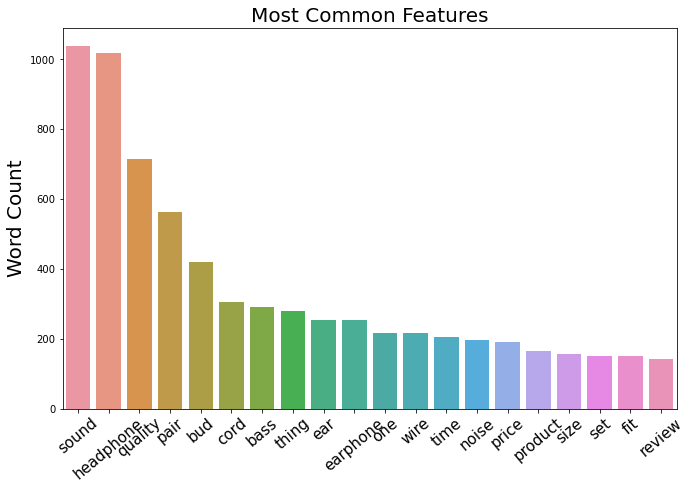

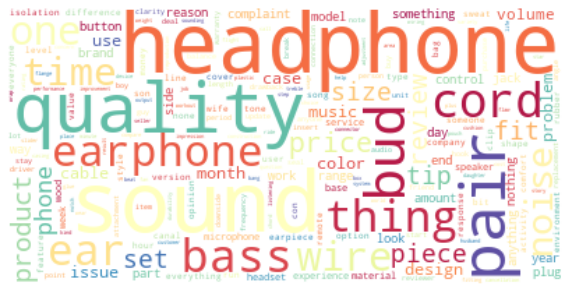

In [445]:
#Frequency Distribution
fdist = FreqDist(features)

#FDist Line Graph
plt.figure(figsize = (5,5))
fdist.plot(20, title = "Frequency distribution for 20 most common Features")

most_common_words = [x[0] for x in fdist.most_common(20)]
counts = [x[1] for x in fdist.most_common(20)]
plt.figure(figsize=(11,7))
plot = sns.barplot(np.arange(20), counts) #width = 0.35)
plt.ylabel("Word Count", fontsize = 20)
plt.xticks(np.arange(20), most_common_words, fontsize=15, rotation=40)
plt.title("Most Common Features", fontsize = 20)
plt.show()

#Word cloud
cloud = WordCloud(max_font_size=60,background_color='white', colormap = 'Spectral').generate_from_frequencies(fdist)
plt.figure(figsize=(10,10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# FREQUENCY TABLE

In [446]:
df_extraction = pd.DataFrame()

kanseis_20 = [pair[0] for pair in Counter(kanseis).most_common(20)]
kanseis_frequencies = [pair[1] for pair in Counter(kanseis).most_common(20)]

features_20 = [pair[0] for pair in Counter(features).most_common(20)]
features_frequencies = [pair[1] for pair in Counter(features).most_common(20)]



df_extraction['kansei'] = kanseis_20
df_extraction['kansei_frequency'] = [str(round((frequency/len(kanseis))*100, 2))+"%" for frequency in kanseis_frequencies]

df_extraction['feature'] = features_20
df_extraction['feature_frequency'] = [str(round((frequency/len(features))*100, 2))+"%" for frequency in features_frequencies]





In [447]:
#df_extraction.to_csv("frequencies_updated.csv")

# EVALUATION OF THE EXTRACTION TECNIQUES

# DIVERSITY

In [448]:
def diversity(words):
    all_words = Counter(words).most_common()
    df = pd.DataFrame()
    words = [pair[0] for pair in all_words]
    frequencies = [pair[1] for pair in all_words]
    cumulative_freqs = []
    for i in range(len(frequencies)):
        cumulative_freqs.append(sum(frequencies[:i+1]))
    df['word'] = words
    df['frequency'] = frequencies
    df['cumulative_freq'] =  cumulative_freqs
    
    top_10_freq_prob = df['cumulative_freq'][9]/max(df['cumulative_freq'])
    diversity_score = 1-top_10_freq_prob
    print(diversity_score)
    return diversity_score


In [449]:
diversity_score_noun_adj_adjectives = diversity(noun_adj_dict['adjectives'])
diversity_score_noun_adj_features = diversity(noun_adj_dict['nouns'])


0.7878394977480552
0.7284971070160937


In [450]:
diversity_score_syntactic_kanseis = diversity(feature_kansei_dict['kanseis'])

diversity_score_syntactic_features = diversity(feature_kansei_dict['features'])


0.7887309847878303
0.6386270924180616


In [451]:
#product_df.to_csv ('product_df.csv', index = False, header=True)


# CONCENTRATION

In [452]:
def concentration(words):
    all_words = Counter(words).most_common()
    df = pd.DataFrame()
    words = [pair[0] for pair in all_words]
    frequencies = [pair[1] for pair in all_words]
    cumulative_freqs = []
    for i in range(len(frequencies)):
        cumulative_freqs.append(sum(frequencies[:i+1]))
        
    df['word'] = words
    df['frequency'] = frequencies
    df['cumulative_freq'] =  cumulative_freqs
    concentration = sum([1 for cumulative_freq in df['cumulative_freq'] if cumulative_freq <= max(df['cumulative_freq'])*0.80])
    print(concentration)
    return concentration
    
    




In [453]:
concentration(noun_adj_dict['adjectives'])
concentration(noun_adj_dict['nouns'])


245
287


287

In [454]:
concentration(feature_kansei_dict['kanseis'])
concentration(feature_kansei_dict['features'])



180
135


135

# LINK ANALYSIS

# Feature Clustering

In [455]:
a = [x[0] for x in Counter(feature_kansei_dict['features']).most_common()]
a

['sound',
 'headphone',
 'quality',
 'pair',
 'bud',
 'cord',
 'bass',
 'thing',
 'ear',
 'earphone',
 'one',
 'wire',
 'time',
 'noise',
 'price',
 'product',
 'size',
 'set',
 'fit',
 'review',
 'piece',
 'tip',
 'phone',
 'design',
 'case',
 'cable',
 'month',
 'problem',
 'music',
 'use',
 'issue',
 'color',
 'volume',
 'complaint',
 'part',
 'side',
 'year',
 'work',
 'day',
 'brand',
 'control',
 'button',
 'something',
 'reason',
 'model',
 'end',
 'range',
 'nothing',
 'plug',
 'amount',
 'look',
 'anything',
 'way',
 'jack',
 'experience',
 'service',
 'week',
 'material',
 'speaker',
 'wood',
 'headset',
 'microphone',
 'base',
 'everything',
 'son',
 'isolation',
 'difference',
 'version',
 'level',
 'money',
 'canal',
 'none',
 'shape',
 'con',
 'bit',
 'earpiece',
 'sweat',
 'line',
 'type',
 'company',
 'clip',
 'option',
 'someone',
 'song',
 'feature',
 'environment',
 'style',
 'wife',
 'response',
 'comfort',
 'cover',
 'everyone',
 'bag',
 'run',
 'tone',
 'hour',
 '

In [456]:
def feature_clustering(words, main_features):
    nlp = spacy.load("en_core_web_md")
    similarity = [[[nlp(str(w)).similarity(nlp(str(main_feature))), (w,main_feature)] for w in words] for main_feature in tqdm(main_features)]
    features = {}
    for i in range(len(similarity)):
        similar_ones = []
        for relation in similarity[i]:
            if relation[0] >= 0.55:
                similar_ones.append(relation[1][0])
                
        features[similarity[i][0][1][1]] = similar_ones
    
    
    return features

In [457]:
x = feature_clustering(a, ['sound', 'comfort', 'quality', 'design'])  ###1) ['sound', 'comfort', 'quality', 'design']2)"sound", "design", "comfort", "price", "quality"


<ipython-input-456-ba9b2e3f4602>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  similarity = [[[nlp(str(w)).similarity(nlp(str(main_feature))), (w,main_feature)] for w in words] for main_feature in tqdm(main_features)]


<ipython-input-456-ba9b2e3f4602>:3: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity = [[[nlp(str(w)).similarity(nlp(str(main_feature))), (w,main_feature)] for w in words] for main_feature in tqdm(main_features)]


In [458]:
x

{'sound': ['sound',
  'bass',
  'noise',
  'music',
  'tone',
  'audio',
  'sounding',
  'listening',
  'voice',
  'recording',
  'muffle',
  'listen',
  'hiss',
  'hissing',
  'hum',
  'tune',
  'squeak',
  'loudness',
  'guitar'],
 'comfort': ['fit',
  'comfort',
  'durability',
  'feel',
  'ease',
  'workmanship',
  'ruggedness'],
 'quality': ['quality',
  'variety',
  'durability',
  'craftsmanship',
  'assortment',
  'reliability',
  'workmanship',
  'ruggedness'],
 'design': ['design',
  'style',
  'construction',
  'concept',
  'layout',
  'interior',
  'engineering',
  'styling']}

In [459]:
#for feature in x.keys():
    #x[feature] = [sub_feature for sub_feature in x[feature] if sub_feature != feature]
#x

In [460]:
features_df = pd.DataFrame()
features_df['Main Feature'] = x.keys()
features_df['Subfeature'] = [x[main_feature] for main_feature in x.keys()]
features_df

,Main Feature,Subfeature
0,sound,"[sound, bass, noise, music, tone, audio, sound..."
1,comfort,"[fit, comfort, durability, feel, ease, workman..."
2,quality,"[quality, variety, durability, craftsmanship, ..."
3,design,"[design, style, construction, concept, layout,..."


# LINK TO KANSEIS

In [461]:

def features_subfeatures_kanseis(feature_dict, review_relation_df):
    features_and_kanseis = {}
    
    for feature in tqdm(feature_dict.keys()):
        sub_feature_dict = {}
        for sub_feature in feature_dict[feature]:
            sub_feature_kanseis = []
            
            empty_kansei_dict = {}
            for i in range(review_relation_df.shape[0]):
                if sub_feature in review_relation_df.iloc[i]['slight']:
                    for relation in review_relation_df.iloc[i]['syntactic_relations']:

                        if (sub_feature, "NN") in relation and relation[2] == "nsub" and (relation[1][0] not in ["much", "very", "too", "ear", "little"] + stop_words) and (lemmatizer.lemmatize(relation[1][0], pos = "a") in words ):
                            if TextBlob(review_relation_df.iloc[i]['slight']).sentiment[0] >0.1:
                                sub_feature_kanseis.append(relation[1][0]+"+")#((relation[1][0], "positive"))
                            else:
                                sub_feature_kanseis.append(relation[1][0]+"-")#((relation[1][0], "negative"))#
                                
                                
                        
                        if (sub_feature, "NN") in relation and relation[2] == "amod" and (relation[0][0] not in ["much", "very", "too", "ear", "little"] + stop_words) and (lemmatizer.lemmatize(relation[0][0], pos = "a") in words ):
                            if TextBlob(review_relation_df.iloc[i]['slight']).sentiment[0] >0.1 :
                                sub_feature_kanseis.append(relation[0][0]+"+")#((relation[0][0], "positive"))
                            else:
                                sub_feature_kanseis.append(relation[0][0]+"-")#((relation[0][0], "negative"))#
                        
                        
                        
                        if (sub_feature, "VB") in relation and relation[2] == "advmod" and relation[0][1] == "RB" and (relation[0][0] not in ["much", "very", "too", "ear", "little", "usually", "always", "either", "neither", "personally", "quitely", "rarely", "always", "importantly"] + stop_words) and (lemmatizer.lemmatize(relation[0][0], pos = "r") in words ):
                            if TextBlob(review_relation_df.iloc[i]['slight']).sentiment[0] >0.1:
                                    sub_feature_kanseis.append(relation[0][0]+"+")
                            else:
                                sub_feature_kanseis.append(relation[0][0]+"-")
                                
                            
                            
            
            
            
            
            for kansei in set(sub_feature_kanseis):
                empty_kansei_dict[kansei] = {} #''

            sub_feature_dict[sub_feature] = empty_kansei_dict
                        
            
        features_and_kanseis[feature] = sub_feature_dict
        
    return features_and_kanseis

In [462]:
trial = features_subfeatures_kanseis(x, product_df[['slight', 'syntactic_relations']])

<ipython-input-461-280c8f521a3e>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for feature in tqdm(feature_dict.keys()):


In [463]:
features_kanseis = trial
#eatures_kanseis['comfort']

In [464]:
###CREATE FEATURE DATAFRAMES

In [466]:
features_df = pd.DataFrame()
features_df['Main Feature'] = [(main_feature, len(features_kanseis[main_feature].keys())) for main_feature in features_kanseis.keys()]


subfeatures = [[(subfeature,len(features_kanseis[main_feature][subfeature].keys())) for subfeature in features_kanseis[main_feature].keys()] for main_feature in features_kanseis.keys()]
features_df['Subfeature'] = subfeatures
features_df

,Main Feature,Subfeature
0,"(sound, 19)","[(sound, 206), (bass, 55), (noise, 46), (music..."
1,"(comfort, 7)","[(fit, 72), (comfort, 4), (durability, 1), (fe..."
2,"(quality, 8)","[(quality, 85), (variety, 6), (durability, 1),..."
3,"(design, 8)","[(design, 48), (style, 15), (construction, 5),..."


In [467]:
#features_df.to_csv("table_features.csv")

In [468]:
###CREATE SUB FEATURE AND KANSEIS DATAFRAME

In [469]:
def feature_table(feature):
    df = pd.DataFrame()
    df['Subfeature'] = feature.keys()
    positives = []
    negatives = []
    pos_count = []
    neg_count = []
    total_counts = []
    for subfeature in df['Subfeature']:
        pos_kansei = [kansei for kansei in feature[subfeature] if "+" in kansei ]
        positives.append(pos_kansei)
        pos_count.append(len(pos_kansei))
        neg_kansei = [kansei for kansei in feature[subfeature] if "-" in kansei ]
        negatives.append(neg_kansei)
        neg_count.append(len(neg_kansei))
        
        total_count = len(pos_kansei) + len(neg_kansei)
        total_counts.append(total_count)
        
    df['Positive Kansei'] = positives
    df['Positive Count'] = pos_count
    df['Negative Kansei'] = negatives
    df['Negative Count'] =neg_count
    df['Total Count'] = total_counts
    df = df[df['Total Count'] != 0]
    
    
    return df



In [470]:
sound = features_kanseis['sound']
comfort = features_kanseis['comfort']
quality = features_kanseis['quality']
design = features_kanseis['design']


In [471]:
s = feature_table(sound)
#s.to_csv("table_sound.csv")
s

,Subfeature,Positive Kansei,Positive Count,Negative Kansei,Negative Count,Total Count
0,sound,"[easily+, noisy+, full+, wise+, properly+, fan...",146,"[irritating-, pristine-, faint-, clear-, suita...",60,206
1,bass,"[distorted+, flawless+, clear+, strong+, power...",38,"[poor-, extra-, deep-, acoustic-, strong-, rob...",17,55
2,noise,"[ambient+, amazing+, significant+, static+, me...",27,"[weird-, less-, audible-, unpleasant-, vibrati...",19,46
3,music,"[clear+, heavy+, loud+, softer+, low+, modern+...",23,"[clear-, heavy-, vocal-, low-]",4,27
4,tone,"[undistorted+, midrange+, rounded+, clear+, qu...",12,"[rich-, high-, deep-, muddy-, mid-]",5,17
5,audio,"[full+, high+, clear+, clean+, mediocre+, bala...",6,"[clear-, sleek-]",2,8
6,sounding,"[comfortable+, tinny+, rich+, decent+, big+, b...",8,"[average-, dull-]",2,10
7,listening,"[serious+, easy+, casual+]",3,"[casual-, basic-, daily-]",3,6
8,voice,"[clear+, high+, normal+, loud+, basic+]",5,[],0,5
9,recording,"[old+, bad+]",2,[new-],1,3


In [472]:
c = feature_table(comfort)
#c.to_csv("table_comfort.csv")
c

,Subfeature,Positive Kansei,Positive Count,Negative Kansei,Negative Count,Total Count
0,fit,"[pro+, differently+, several+, comfortable+, c...",51,"[typically-, solid-, perfectly-, also-, custom...",21,72
1,comfort,"[personal+, quality+, quiet+, incredible+]",4,[],0,4
2,durability,[quality+],1,[],0,1
3,feel,"[hardly+, comfortable+, pretty+, even+, cushio...",14,"[quality-, differently-, never-]",3,17
4,ease,[relative+],1,[],0,1
5,workmanship,[shoddy+],1,[],0,1
6,ruggedness,[superior+],1,[],0,1


In [474]:
q = feature_table(quality)
#q.to_csv("table_quality.csv")
q

,Subfeature,Positive Kansei,Positive Count,Negative Kansei,Negative Count,Total Count
0,quality,"[fantastic+, low+, listening+, horrid+, solid+...",60,"[supreme-, terrible-, long-, sound-, audiophil...",25,85
1,variety,"[wide+, many+, large+, huge+, maniacal+]",5,[wide-],1,6
2,durability,[quality+],1,[],0,1
3,craftsmanship,[],0,[shoddy-],1,1
6,workmanship,[shoddy+],1,[],0,1
7,ruggedness,[superior+],1,[],0,1


In [475]:
d = feature_table(design)
#d.to_csv("table_design.csv")
d

,Subfeature,Positive Kansei,Positive Count,Negative Kansei,Negative Count,Total Count
0,design,"[sturdy+, comfortable+, amazing+, clear+, expl...",37,"[poor-, angled-, straight-, previous-, new-, w...",11,48
1,style,"[extra+, new+, unique+, many+, closed+, old+, ...",11,"[old-, musical-, several-, different-]",4,15
2,construction,"[cheap+, durable+, plastic+]",3,"[flimsy-, terrible-]",2,5
3,concept,[],0,[flexible-],1,1
4,layout,[],0,[deceptive-],1,1
5,interior,[soft+],1,[],0,1


# GET FEATURES 

In [476]:
def get_main_features(feature_dict, product_name):
    main_feature_dict = {}
    for feature in feature_dict.keys():
        main_feature_dict[feature] = {}

    main_features = {product_name: main_feature_dict }    
   
    return main_features                      

In [477]:
def get_sub_features(feature_dict, main_feature):
    sub_feature_dict = {}
    for sub_feature in feature_dict[main_feature]:
        sub_feature_dict[sub_feature] = {}
        
    sub_features = {main_feature: sub_feature_dict}    
        
        
        
    return sub_features
                        

# VISUALISATION OF RELATIONSHIPS

In [478]:
main_features = get_main_features(x, "earbud")
sound_sub_features = get_sub_features(x, 'sound')
comfort_sub_features = get_sub_features(x, 'comfort')
quality_sub_features = get_sub_features(x, 'quality')
design_sub_features = get_sub_features(x, 'design')

In [479]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

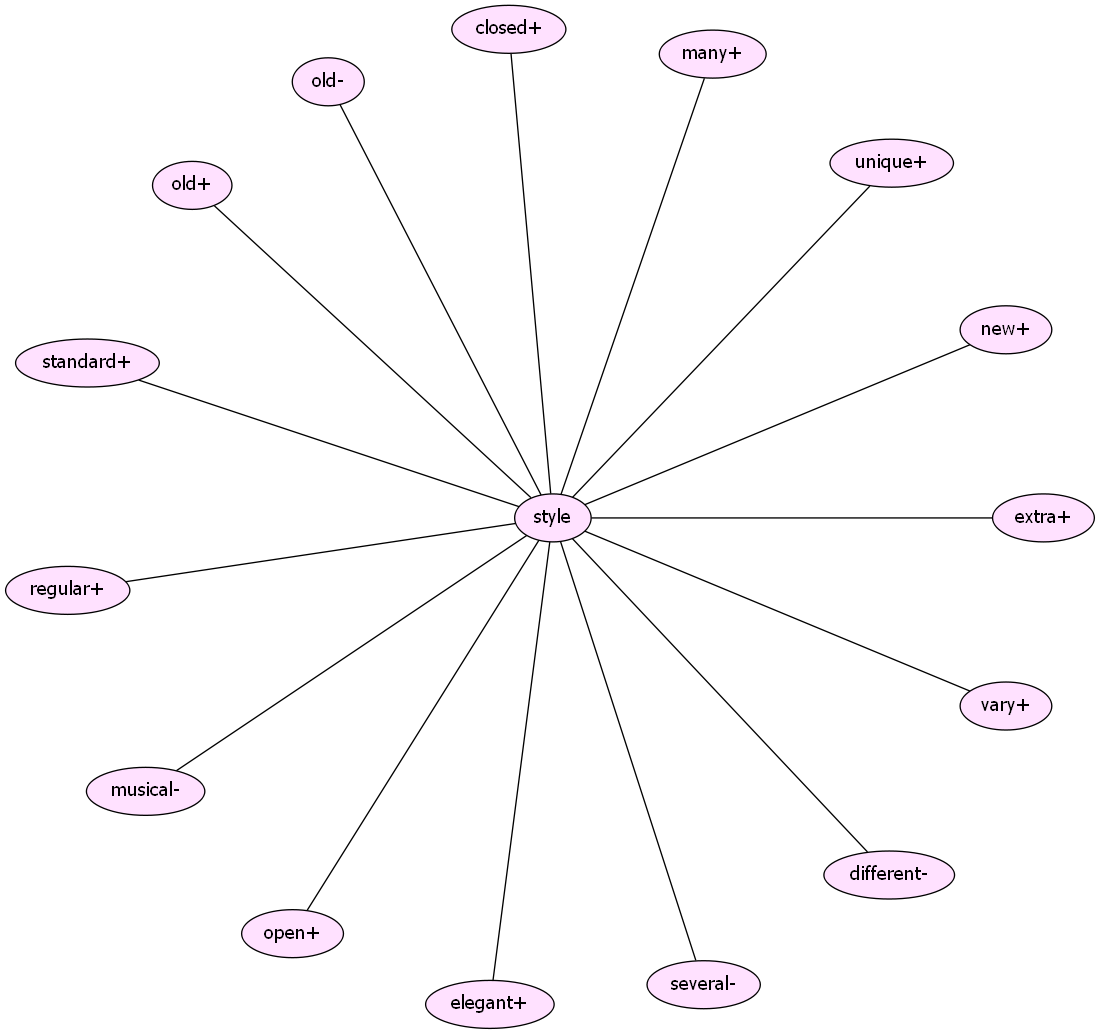

In [494]:
#####DRAW TREE
import pydot

import pydot

#feature = main_features

def draw(parent_name, child_name):
    edge = pydot.Edge(parent_name, child_name)
    graph.add_edge(edge)

def relation(node, parent=None):
    for k,v in node.items():
        if isinstance(v, dict):
            # We start with the root node whose parent is None
            # we don't want to graph the None node
            if parent:
                draw(parent, k)
            relation(v, k)
        else:
            draw(parent, k)
            # drawing the label using a distinct name
            draw( k+'_'+v)#(k, k+'_'+v)
    
graph = pydot.Dot(graph_type='graph',nodesep="0", center=True, layout="circo")
#graph = pydot.Dot(graph_type='graph',nodesep="0", center=True)

graph.set_node_defaults(style="filled", fillcolor="thistle1", fontname= "Ariel") #style:'rounded'
graph.set_edge_defaults(color="black", arrowhead="vee")

relation({'style': features_kanseis['design']['style']})
#relation(design_sub_features)


from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)
    
import networkx as nx
to_pdot = nx.drawing.nx_pydot.to_pydot
pdot = to_pdot(nx.complete_graph(5))
view_pydot(graph)